### Mount drive

In [ ]:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Include library


In [ ]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import random
from concurrent.futures import ThreadPoolExecutor, as_completed

### Data processing

In [ ]:
path = '/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Train/crop_part1'
files = os.listdir(path)

In [ ]:
image_files = random.sample(files, 9780)

In [ ]:
input = []
target_age = []
for filename in image_files:
  if filename.endswith(".jpg"):
    actual_age = int(filename.split('_')[0])
    if actual_age >= 0 and actual_age <= 6:
      target_age.append(0)  # Trẻ em
    elif actual_age >= 7 and actual_age <= 19:
      target_age.append(1)  # Thiếu niên
    elif actual_age >= 20 and actual_age <=32 :
      target_age.append(2)  # Thanh niên
    elif actual_age >= 33 and actual_age <= 55:
      target_age.append(3)  # Trung niên
    else:  # actual_age >= 55
      target_age.append(4)  # Người cao tuổi
    input.append(path + '/' + filename)
  else:
    continue


In [ ]:
  from collections import Counter

  age_counts = Counter(target_age)

  print("Số lượng Trẻ em:", age_counts[0])
  print("Số lượng Thiếu niên:", age_counts[1])
  print("Số lượng Thanh niên:", age_counts[2])
  print("Số lượng Trung niên:", age_counts[3])
  print("Số lượng Người cao tuổi:", age_counts[4])


Số lượng Trẻ em: 2425
Số lượng Thiếu niên: 1739
Số lượng Thanh niên: 1864
Số lượng Trung niên: 1953
Số lượng Người cao tuổi: 1799


In [ ]:
# cnt = 0
# for x in age_counts:
#   cnt+= len(x)

# print(cnt)

In [ ]:
# Function to perform undersampling
def undersample(input_list, target_list, max_samples):
    indices = list(range(len(target_list)))
    random.shuffle(indices)
    sampled_indices = indices[:max_samples]
    return [input_list[i] for i in sampled_indices], [target_list[i] for i in sampled_indices]

In [ ]:
# Determine the maximum number of samples per age group (e.g., 1000)
max_samples = 2000

# Create a balanced dataset
balanced_input = []
balanced_target_age = []
# Apply undersampling for each age group
for age_group in set(target_age):
    group_indices = [i for i, age in enumerate(target_age) if age == age_group]
    group_input = [input[i] for i in group_indices]
    group_target_age = [target_age[i] for i in group_indices]
    if len(group_target_age) > max_samples:
        group_input, group_target_age = undersample(group_input, group_target_age, max_samples)
    balanced_input.extend(group_input)
    balanced_target_age.extend(group_target_age)

In [ ]:
from collections import Counter

age_counts = Counter(balanced_target_age)

print("Số lượng Trẻ em:", age_counts[0])
print("Số lượng Thiếu niên:", age_counts[1])
print("Số lượng Thanh niên:", age_counts[2])
print("Số lượng Trung niên:", age_counts[3])
print("Số lượng Người cao tuổi:", age_counts[4])

Số lượng Trẻ em: 2000
Số lượng Thiếu niên: 1739
Số lượng Thanh niên: 1864
Số lượng Trung niên: 1953
Số lượng Người cao tuổi: 1799


In [ ]:
print(len(age_counts))

5


In [ ]:
def canny_edge_detection(img_gray, minthreshold= 50, maxthreshold = 100):
    """
    image_path: link to image
    threshold1: min threshold
    threshold2: max threshold
    """
    # Perform Canny edge detection
    edges = cv2.Canny(img_gray, minthreshold, maxthreshold)

    return edges

In [ ]:
def process_image(img_file):
    try:
        img = cv2.imread(img_file)
        img = cv2.resize(img, (128, 128))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_canny = canny_edge_detection(gray, 50, 100)
        filename = os.path.basename(img_file)
        gender = int(filename.split('_')[1])
        return img_canny, gender
    except Exception as e:
        print(f"Error processing {img_file}: {e}")
        return None, None

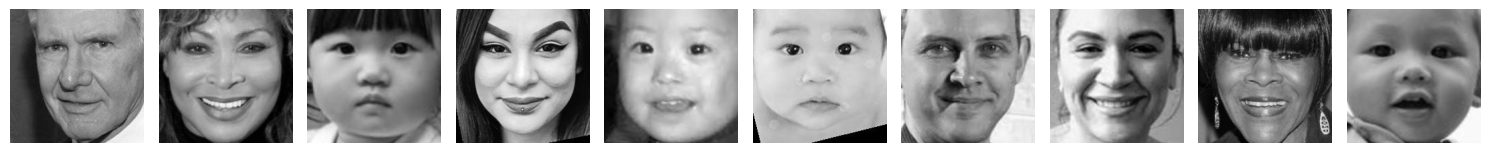

In [ ]:
number_img = 10

fig, axes = plt.subplots(1, number_img, figsize=(15, 5))
for i, img_files in enumerate(image_files[0:number_img]):
  image_path = os.path.join(path, img_files)
  img = cv2.imread(image_path)

  # convert BGR to gray
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  axes[i].imshow(gray, cmap='gray')
  axes[i].axis('off')

plt.tight_layout()
plt.show()

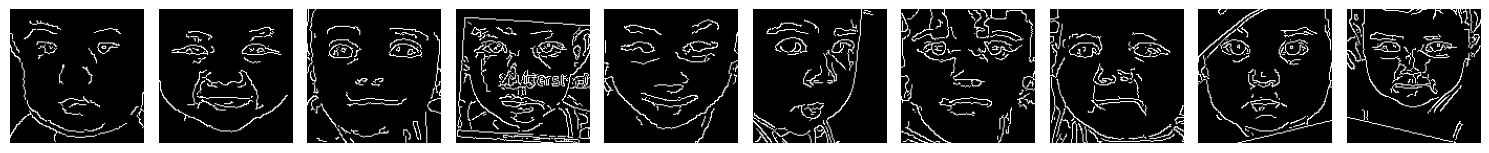

In [ ]:
data = []
target_gender = []

# Number of images to visualize
number_img = 10
fig, axes = plt.subplots(1, number_img, figsize=(15, 5))

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=8) as executor:
    future_to_img = {executor.submit(process_image, img_file): img_file for img_file in balanced_input}
    for i, future in enumerate(as_completed(future_to_img)):
        img_canny, gender = future.result()
        if img_canny is not None:
            data.append(img_canny)
            target_gender.append(gender)
            # Display the first number_img images
            if i < number_img:
                axes[i].imshow(img_canny, cmap='gray')
                axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Convert data and targets to numpy arrays
data = np.array(data)
target_gender = np.array(target_gender)
target_age = np.array(balanced_target_age)

In [ ]:
  print(f"shape of data: {data.shape}")
  print(f"shape of target age: {target_age.shape}")
  print(f"shape of target gender: {target_gender.shape}")
  print(target_age)

shape of data: (9355, 128, 128)
shape of target age: (9355,)
shape of target gender: (9355,)
[0 0 0 ... 4 4 4]


### Visualizing data

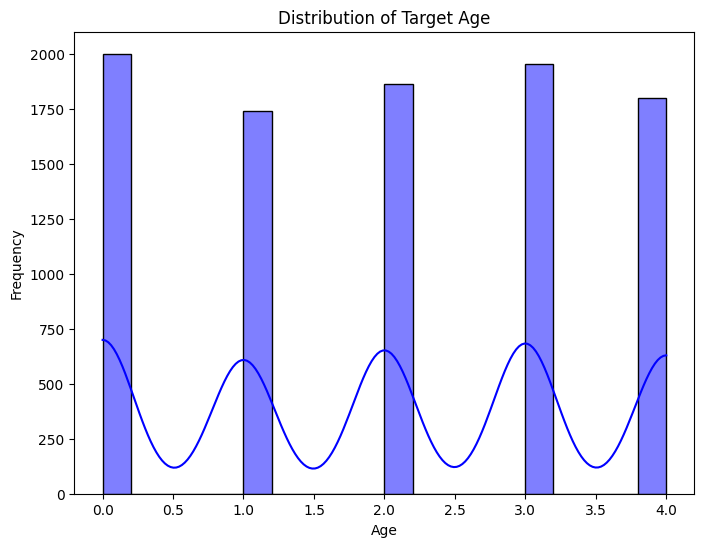

In [ ]:
# Plotting target age
plt.figure(figsize=(8, 6))
sns.histplot(target_age, bins=20, kde=True, color='blue')
plt.title('Distribution of Target Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

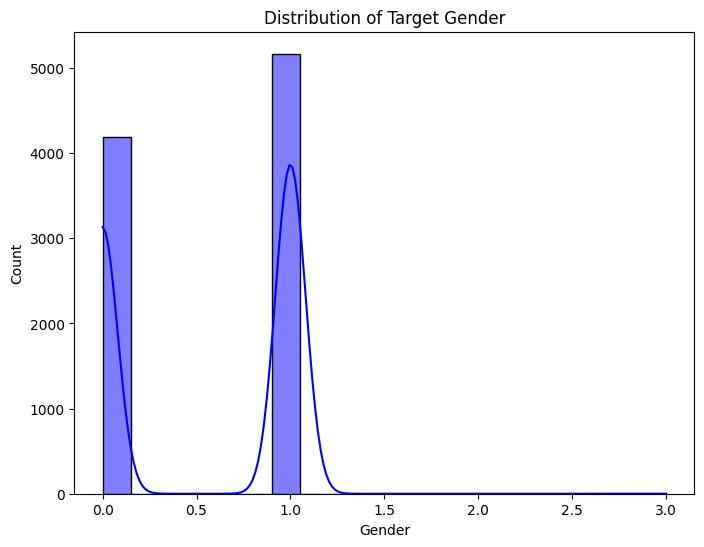

In [ ]:
# Plotting target gender
plt.figure(figsize=(8, 6))
sns.histplot(target_gender, bins=20, kde=True, color='blue')
plt.title('Distribution of Target Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### Split data

In [ ]:
  # Split the data into train and test sets
  X_train, X_test, y_train_gender, y_test_gender, y_train_age, y_test_age = train_test_split(data, target_gender, target_age, test_size=0.2, random_state=42)

  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
  print(f"shape of X train: {X_train.shape}")
  print(f"shape of target age: {target_age.shape}")
  print(f"shape of target gender: {target_gender.shape}")

shape of X train: (7484, 16384)
shape of target age: (9355,)
shape of target gender: (9355,)


### Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### PCA

In [ ]:
from sklearn.decomposition import PCA
# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
X_train_pca.shape

(7484, 100)

#### Random Forest

In [ ]:
rf_age = RandomForestClassifier(n_estimators=300)
rf_age.fit(X_train_pca, y_train_age)
rf_gender = RandomForestClassifier(n_estimators=100)
rf_gender.fit(X_train_pca, y_train_gender)
y_pred_age = rf_age.predict(X_test_pca)
y_pred_gender = rf_gender.predict(X_test_pca)

In [ ]:
# rf_age = RandomForestClassifier(n_estimators = 300)

### Evaluation

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_gender, y_pred_gender))

              precision    recall  f1-score   support

           0       0.75      0.62      0.68       830
           1       0.73      0.83      0.78      1040
           3       0.00      0.00      0.00         1

    accuracy                           0.74      1871
   macro avg       0.49      0.49      0.49      1871
weighted avg       0.74      0.74      0.74      1871



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_test_age, y_pred_age))

              precision    recall  f1-score   support

           0       0.72      0.84      0.77       401
           1       0.50      0.36      0.41       332
           2       0.51      0.58      0.54       393
           3       0.46      0.51      0.48       392
           4       0.60      0.50      0.55       353

    accuracy                           0.56      1871
   macro avg       0.56      0.55      0.55      1871
weighted avg       0.56      0.56      0.56      1871



In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_age, y_pred_age)

array([[335,  29,  23,   9,   5],
       [ 58, 118,  88,  42,  26],
       [ 33,  42, 226,  73,  19],
       [ 18,  30,  78, 198,  68],
       [ 22,  19,  30, 105, 177]])

In [ ]:
def equalize_brightness(image):
    # Convert the image to YUV color space
    yuv_img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # Apply CLAHE to the Y channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    yuv_img[:, :, 0] = clahe.apply(yuv_img[:, :, 0])
    # Convert the YUV image back to BGR format
    equalized_img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2BGR)
    return equalized_img

In [ ]:
def process_and_predict(file):
    img_origin = cv2.imread(file)
    if img_origin is None:
        raise ValueError(f"Image not found at path: {file}")

    img = cv2.resize(img_origin, (128, 128))

    img_equalized = equalize_brightness(img)

    # Convert BGR to gray
    gray = cv2.cvtColor(img_equalized, cv2.COLOR_BGR2GRAY)
    img_canny = canny_edge_detection(gray, 50, 100)

    # Flatten and reshape for model input
    img_canny = img_canny.flatten().reshape(1, -1)

    # Scale the features (assuming scaler is already fitted on training data)
    img_canny = scaler.transform(img_canny)

    # Apply PCA for dimensionality reduction (assuming pca is already fitted on training data)
    img_canny = pca.transform(img_canny)

    # Predict age and gender
    age = rf_age.predict(img_canny)
    gender = rf_gender.predict(img_canny)

    # Interpret the results
    gender_label = 'male' if gender == 0 else 'female'
    age_labels = ['0-12', '13-19', '20-35', '36-50', '51+']
    age_label = age_labels[age[0]]

    # Display the original image with prediction results
    img_rgb = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f'Age: {age_label} \nGender: {gender_label}')
    plt.axis('off')
    plt.show()

In [ ]:
import requests
from io import BytesIO
from PIL import Image

In [ ]:
def process_and_predict_url(url):
    # Download image from URL
    response = requests.get(url)
    img_origin = Image.open(BytesIO(response.content))
    img_origin = cv2.cvtColor(np.array(img_origin), cv2.COLOR_RGB2BGR)

    # Resize image
    img = cv2.resize(img_origin, (128, 128))

    # Equalize brightness
    img_equalized = equalize_brightness(img)

    # Convert BGR to gray
    gray = cv2.cvtColor(img_equalized, cv2.COLOR_BGR2GRAY)
    img_canny = canny_edge_detection(gray, 50, 100)

    # Flatten and reshape for model input
    img_canny = img_canny.flatten().reshape(1, -1)

    # Scale the features (assumes scaler is already fitted on training data)
    img_canny = scaler.transform(img_canny)

    # Apply PCA for dimensionality reduction (assuming pca is already fitted on training data)
    img_canny = pca.transform(img_canny)

    # Predict age and gender
    age = rf_age.predict(img_canny)
    gender = rf_gender.predict(img_canny)

    # Interpret the results
    gender_label = 'male' if gender == 0 else 'female'
    age_labels = ['0-12', '13-19', '20-35', '36-50', '51+']
    age_label = age_labels[age[0]]

    # Display the original image with prediction results
    img_rgb = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f'Age: {age_label} \nGender: {gender_label}')
    plt.axis('off')
    plt.show()

In [ ]:
def process_and_show_canny(url):
    # Download image from URL
    response = requests.get(url)
    img_origin = Image.open(BytesIO(response.content))
    img_origin = cv2.cvtColor(np.array(img_origin), cv2.COLOR_RGB2BGR)

    # Resize image
    img = cv2.resize(img_origin, (128, 128))
    img_equalized = equalize_brightness(img)

    # Convert BGR to gray
    gray = cv2.cvtColor(img_equalized, cv2.COLOR_BGR2GRAY)
    img_canny = canny_edge_detection(gray, 100, 200)

    # Display the original image and the edge-detected image
    img_rgb = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img_rgb)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(img_canny, cmap='gray')
    axs[1].set_title('Canny Edge Detection')
    axs[1].axis('off')

    plt.show()

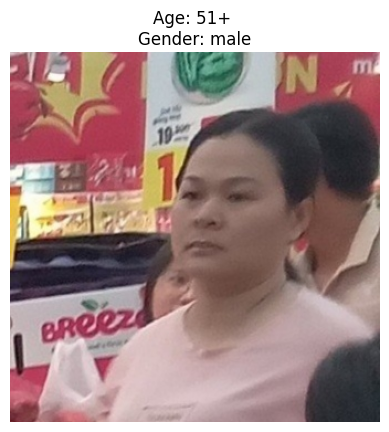

In [ ]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img17.jpg')


In [ ]:
# process_and_predict_url('https://dk.pinterest.com/pin/677651075206546723')

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x785e966b0ef0>

In [ ]:
import joblib

In [ ]:
joblib_file = "/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Age_RandomForest_Model.pkl"
joblib.dump(rf_age, joblib_file)

['/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Age_RandomForest_Model.pkl']

In [ ]:
joblib_file = "/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Gender_RandomForest_Model.pkl"
joblib.dump(rf_gender, joblib_file)

['/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Gender_RandomForest_Model.pkl']

In [ ]:
# Load from file

Gender_model = joblib.load('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Age_RandomForest_Model.pkl')


Gender_model

RandomForestClassifier(n_estimators=300)

In [ ]:
# Load from file

Age_model = joblib.load('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Gender_RandomForest_Model.pkl')


Age_model

RandomForestClassifier()